In [4]:
import atm_coeffs as ac
import resp_delta as rd
import irrad_func as ir

In [5]:
import h5py
import numpy as np
from scipy import interpolate as inp
from scipy.integrate import quad as integrate
from scipy.special import legendre, lpmv, sph_harm
from scipy.optimize import fsolve
from random import random as rand
import inspect

from PyAstronomy import pyasl

import f90nml as nmlre
from shutil import copyfile

import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib notebook

### Read Gyre output

In [102]:
class resp_coeffs:
    
    def __init__ (self, response_file):
        
        self.data = self.read_response(response_file)
        
        # Sanity check
        
        if len(self.data) == 0:
            raise Exception('Empty response file')
        if not isinstance(self.data, dict):
            raise Exception('Response file type error')
            
        # Setup axes
        
        n_l = self.data['l_max']
        n_m = 2*n_l
        n_k = self.data['k_max']
        
        self.R_lmk = np.empty([n_l+1, n_m+1, n_k+1], dtype=complex)
        self.T_lmk = np.empty([n_l+1, n_m+1, n_k+1], dtype=complex)
        self.G_lmk = np.empty([n_l+1, n_m+1, n_k+1], dtype=complex)
        
        for l in range(2, n_l+1):
            for m in range(-l, l+1):
                for k in range(0, n_k+1):
                    
                    i_l = l
                    i_m = m + n_l
                    i_k = k

                    self.R_lmk[i_l,i_m,i_k] = self.find_Delta_R(i_l,i_m,i_k)
                    self.T_lmk[i_l,i_m,i_k] = self.find_Delta_T(i_l,i_m,i_k)
                    self.G_lmk[i_l,i_m,i_k] = self.find_Delta_G(i_l,i_m,i_k, m,k)
        
        
    def read_response(self, filename):
    
        # Read data from gyre_response
        
        if filename == '':
            
            # Fabricate dummy data
            
            xi_r_ref_re = np.zeros((0,0,0))
            xi_r_ref_im = np.zeros((0,0,0))
            
            lag_L_ref_re = np.zeros((0,0,0))
            lag_L_ref_im = np.zeros((0,0,0))
            
            l_max = 0
            k_max = 0
            
            # These may need tweaking; in any case, we should be picking
            # up Omega_orb from elsewhere
            
            Omega_rot = 0.
            Omega_orb = 0.
            
        else:
            
            f = h5py.File(filename, 'r')
            
            xi_r_ref_re = f['xi_r']['re'][...]
            xi_r_ref_im = f['xi_r']['im'][...]
            
            lag_L_ref_re = f['lag_L']['re'][...]
            lag_L_ref_im = f['lag_L']['im'][...]
            
            k_max = f.attrs['k_max']
            l_max = f.attrs['l_max']
            
            Omega_rot = f.attrs['Omega_rot']
            Omega_orb = f.attrs['Omega_orb']
            
            f.close()
        
        return {'xi_r_ref': xi_r_ref_re + 1j*xi_r_ref_im,
                'lag_L_ref': lag_L_ref_re + 1j*lag_L_ref_im,
                'k_max': k_max,
                'l_max': l_max,
                'Omega_rot': Omega_rot,
                'Omega_orb': Omega_orb}
    
    
    def find_Delta_R(self, i_l,i_m,i_k):
    
        return np.sqrt(4.*np.pi) * self.data['xi_r_ref'][i_k,i_m,i_l]
        
        
    def find_Delta_T(self, i_l,i_m,i_k):
            
        xi_r_ref = self.data['xi_r_ref'][i_k,i_m,i_l]
        
        lag_L_ref = self.data['lag_L_ref'][i_k,i_m,i_l]
        
        return np.sqrt(4.*np.pi)*(lag_L_ref - 2*xi_r_ref)/4.
      
    
    def find_Delta_G(self, i_l,i_m,i_k, m,k):
    
        xi_r_ref = self.data['xi_r_ref'][i_k,i_m,i_l]
        
        omega = -k*self.data['Omega_orb'] - m*self.data['Omega_rot']
        
        return np.sqrt(4*np.pi)*(-omega**2 - 2)*xi_r_ref

In [6]:
class atm_coeffs:
    
    def __init__ (self, intensity_file):
        
        # input to be replaced by Teff, logg
        
        self.data = self.read_intensity(intensity_file)
        
        self.info = self.read_info(intensity_file)
        
        self.R_xl = {}
        self.T_xl = {}
        self.G_xl = {}
        
        for x in self.info:
            
            self.R_xl[x] = self.find_coeffs('R',x)
            self.T_xl[x] = self.find_coeffs('T',x)
            self.G_xl[x] = self.find_coeffs('G',x)
    
    
    def read_intensity(self, filename):
        
        return h5py.File(filename, 'r')
    
    
    def read_info(self, filename):
        
        moments = self.read_intensity(filename)
        
        colors = []
        ells = []

        for moment in list(moments):
            words = moment.split('_')
            
            if len(words)==2:
                if words[-1] not in colors:
                    colors.append(words[-1])
                    
            if len(words)==3:
                if int(words[-1]) not in ells:
                    ells.append(int(words[-1]))
                    
        l_min, l_max = min(ells), max(ells)
        
        info = {}
        
        for color in colors:
            info[color] = {'l_min':l_min, 'l_max':l_max}
        
        return info
    
            
    def find_coeffs(self, C, x, l=None):
        
        I = self.data
        
        def find_coeffs_C(I, C, x, l):
            
            if C=='R': 
                return (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:]
        
            if C=='T':
                return I[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:]
        
            if C=='G':
                return I[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:]
            
        C_x = {} 
        
        if l==None:

            n_l = self.info[x]['l_max'] # - self.info[x]['l_min'] 
            #this may break if l_min =/= 0
        
            for l in np.arange(n_l+1,dtype=int):
                C_x[l] = find_coeffs_C(I,C,x,l)[0]
            return C_x
        
        elif isinstance(l,int):
            C_x[l] = find_coeffs_C(I,C,x,l)[0]
            return C_x
        
        else:
            raise Exception('TypeError: l must be int or int array')

In [7]:
class star:
    
    def __init__ (self, list_path, star_number):
        
        # should check if 'inlist', this just checks 'str'
        
        if isinstance(list_path, str):
            self.nml = nml.read(list_path)[f'star_{star_number}']
        else: raise Exception('Inlist file error')
            
        self.par = self.read_mesa_params(self.nml['star_model_path'])
        
        self.res = resp_coeffs(self.nml['tide_model_path'])
        
        self.atm = self.read_atm_coeffs(self.nml['star_model_path'])
        
            
    def read_mesa_params(self, mesa_model_path, units='SOL'):
        
        data = ascii.read(mesa_model_path, data_start=0, data_end=1)
        
        # cgs constants
        
        R_sol = 6.957e10 
        M_sol = 1.989e33
        L_sol = 3.839e33
        G = 6.674079999999999e-08 
        sigma_sb = 5.6703669999999995e-05
        
        # data in cgs
        
        m = data[0][1]
        r = data[0][2]
        l = data[0][3]
            
        # calculate Teff [K], logg [dex]
        
        Teff = (l/(sigma_sb * 4*np.pi*r**2))**0.25
        
        g_surf = G*m/(r**2)
        
        logg = np.log10(g_surf)
        
        # convert to solar units
        
        if units=='SOL':
            m = m/M_sol
            r = r/R_sol
            l = l/L_sol
            
        return {'M': m,
                'R': r,
                'L': l,
                'Teff': Teff,
                'logg': logg}
            
            
    def read_atm_coeffs(self, inlist):
        
        Teff = self.par['Teff']
        logg = self.par['logg']
        
        #atm = atm_coeffs(Teff,logg)
        
        return atm_coeffs('data/iOri-partials.h5')

In [119]:
class binary:
    
    def __init__ (self, list_path):
        
        # should check if 'inlist', this just checks 'str'
        
        if isinstance(list_path, str):
            self.nml = nml.read(list_path)
        else: raise Exception('Inlist file error')
        
        self.star = {1: star(list_path, 1),\
                     2: star(list_path, 2) }
        
        self.orbit = self.read_orbit(self.nml)
            
        
    def read_orbit(self, inlist):
        
        orb_list = inlist['orbit']
        
        params = {}
        
        #placeholder unit routine
        
        if orb_list['omega_orb_units']=='CYC_PER_DAY':
            omega_orb_units = 1 
        else: omega_orb_units = 1
        
        if orb_list['a_units']=='CM':
            a_units = 6.957e10 #cm per r_sol
        else: a_units = 1
            
        # eventually, we want to get these from resp_data
        # resp_data currently does not contain this output tho
        
        params['a'] = orb_list['a']*a_units
        params['e'] = orb_list['e']
        params['Omega_orb'] = orb_list['omega_orb']*omega_orb_units
        
        return params

In [9]:
class irradiation:
    
    def __init__ (self, bin_data, star_number):
        
        # prep for find_bin_sep()
        
        self.e = bin_data.orbit['e']
        self.a = bin_data.orbit['a']
        self.Omega_orb = bin_data.orbit['Omega_orb']
        
        # prep for eval_irrad()
        
        if int(star_number)==1:
            star_neighbor = 2
        elif int(star_number)==2:
            star_neighbor = 1
        else:
            raise Exception('Star unspecified')
        
        self.atm_data = bin_data.star[star_number].atm.data
        self.res_data = bin_data.star[star_number].res.data
        
        self.L1 = bin_data.star[star_number].par['L']
        self.R1 = bin_data.star[star_number].par['R']
        self.L2 = bin_data.star[star_neighbor].par['L']
        
            
    def eval_ramp (self, l, m):
        
        term1 = 2* np.sqrt( ((2*l+1)/(4*np.pi)) \
                           *(np.math.factorial(l-m)/np.math.factorial(l+m)) )
        
        if (np.abs(m)==1):
            term2 = np.pi/2
        else:
            term2 = np.cos(m*np.pi/2)/(1-m**2)
        
        # Can I do this integral using symbolic mu, (as I do below)
        # or should I stick to integrating only those mu which I have data for?
        
        term3, term3_err = integrate(lambda mu: np.sqrt(1-mu**2)*lpmv(m,l, mu), -1, 1)
        
        Z_lm = term1*term2*term3
        
        return Z_lm
    
    
    def find_disk_intg_factor (self, l, x):
        
        # I still don't know if I need a bandpass correction, or if defining b_l
        # using the bandpass corrected intensities (as I do here) is sufficient.
    
        b_l = self.atm_data[f'I_{x}_{l}'][:]/self.atm_data[f'I_{x}_0'][:]
    
        return b_l[0]
        
    
    def find_mean_anom (self, t, t_peri=0):
        
        return self.Omega_orb*(t - t_peri)
        
    
    def find_ecce_anom (self, M):
    
        Keppler = lambda E : E - self.e*np.sin(E) - M
        
        return fsolve(Keppler, 0)[0]
        
    
    def find_true_anom (self, E):
    
        return 2*np.arctan( ((1+self.e)/(1-self.e))*np.tan(E/2) )
    
    
    def convert_t_to_f (self, t, t_peri=0):
    
        M = self.find_mean_anom(t, t_peri)
        
        E = self.find_ecce_anom(M)
        
        f = self.find_true_anom(E)
        
        return f
    
    
    def find_bin_sep (self, t, t_peri=0):
        
        f = self.convert_t_to_f(t, t_peri)#* 2*np.pi
        
        D = self.a*(1-self.e**2)/(1+self.e*np.cos(f))
        
        return D
    
    
    def find_irrad (self, x, t, t_peri=0):
        
        Dt = self.find_bin_sep(t, t_peri)
        
        rel_dJ = np.zeros_like(t)
        
        n_l = self.res_data['l_max']
        
        for l in range(2, n_l+1):
            for m in range(-l, l+1):
                
                Z_lm = self.eval_ramp(l, m)
                b_l = self.find_disk_intg_factor(l, x)
                rel_dJ += b_l*Z_lm*(self.L2/self.L1)*(self.R1/Dt)**2
        
        return rel_dJ
        
            #dJ/unperturbed_observed_flux 
            # = bandpass_correction_coefficient*(L2/L1)*(R1/D(t))**2
            #   * disc_integral_factor_(Burkart_used_Eddington_limb_darkening)
            

In [140]:
class observer:
    
    def __init__ (self, list_path):
        
        if isinstance(list_path, str):
            self.nml = nml.read(list_path)
        else: raise Exception('Inlist file error')
    
        self.bin_data = binary(list_path)
        
        self.irr = {1: irradiation(self.bin_data, 1),\
                    2: irradiation(self.bin_data, 2)}
        
    
    def convert_coords (self, inc, omega):

        theta = inc/180 * np.pi
        phi = (90-omega)/180 * np.pi
        
        return theta, phi
        
    
    def calc_bol_I (self, I_0, l):
        
        if l == 0:
            I_l = 1
        elif l == 1:
            I_l = 1/3
        elif l == 2:
            I_l = 1/8
        elif l == 3:
            I_l = 0
        elif l == 4:
            I_l = -1/48
        elif l == 5:
            I_l = 0
        elif l == 6:
            I_l = 1/128
        else:
            raise Exception('No I_l defined')
            
        return I_l*I_0
            
    
    def eval_fourier (self, star_number, inc, omega, x, bol=False):
        
        res = self.bin_data.star[star_number].res
        atm = self.bin_data.star[star_number].atm
        
        theta, phi = self.convert_coords(inc, omega)
        
        # Initialize the frequencies/amplitudes arrays
        
        f = np.arange(res.data['k_max']+1)*res.data['Omega_orb']
        
        A = np.zeros(res.data['k_max']+1, dtype=np.complex)
            

        # Loop over l, m and k
        I = atm.data
    
        for l in range(2, res.data['l_max']+1):
            for m in range(-l, l+1):
                for k in range(0, res.data['k_max']+1):

                    i_l = l
                    i_m = m + res.data['l_max']
                    i_k = k

                    dR_lmk = res.R_lmk[i_l,i_m,i_k]
                    dT_lmk = res.T_lmk[i_l,i_m,i_k]
                    dG_lmk = res.G_lmk[i_l,i_m,i_k]

                    Y_lm = sph_harm(m, l, phi, theta)
                    
                    R_xl = (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:]
                    T_xl = I[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:] 
                    G_xl = I[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:]
                    
                    if bol==True:
                        I_l = self.calc_bol_I( I[f'I_{x}_0'][:], l)
                        R_xl = (2 + l)*(1 - l)*I_l / I[f'I_{x}_0'][:]
                        T_xl = 4*I_l / I[f'I_{x}_0'][:] 
                        G_xl = 0
                    
                    if k == 0:
                        if m == 0:
                            kappa = 0.5
                        elif m >= 1:
                            kappa = 1.
                        else:
                            kappa = 0.
                    else:
                        kappa = 1.
    
                    # Add the Fourier contribution * spherical harmonic
                    
                    A[i_k] += 2*kappa*(dR_lmk*R_xl + dT_lmk*T_xl + dG_lmk*G_xl)*Y_lm
        
        # Return data
        
        return f, A
    

    def find_star_flux (self, star_number, inc, omega, x, t, t_peri=0, bol=False):
        
        res = self.bin_data.star[star_number].res
        Omega_orb = self.bin_data.orbit['Omega_orb']
        
        f, A = self.eval_fourier(star_number, inc, omega, x, bol)
        
        # Initialize the frequencies/amplitudes arrays
        
        if isinstance(t, np.ndarray):
            
            star_flux = np.zeros_like(t)
        
        elif isinstance(t, list):
            
            t = np.array(t)
            star_flux = np.zeros_like(t)
            
        else: #How to isinstance any mathable t? float, int, etc?
            
            star_flux = 0.

        # Add contributions from each frequency component

        n_A = len(A)

        for i in range(n_A):
            
            star_flux += np.real(A[i] * np.exp(-1j*f[i]*2*np.pi*(t - t_peri)))
            
        return star_flux
    
    
    def find_flux (self, inc, omega, x, t, t_peri=0, bol=False):
        
        irr_1 = self.irr[1].find_irrad(x, t, t_peri)
        irr_2 = self.irr[2].find_irrad(x, t, t_peri)
        
        star_1 = self.find_star_flux(1, inc, omega, x, t, t_peri, bol)
        star_2 = self.find_star_flux(2, inc, omega, x, t, t_peri, bol)
        
        return irr_1 + star_1 + irr_2 + star_2
    

In [144]:
def run_observer(bin_list):
    
    # Setup observer
    
    obs = observer(bin_list)
    
    inc = obs.nml['observer']['inc']
    omega = obs.nml['observer']['omega']
    x = obs.nml['observer']['bandpass']
    
    t_units = 1/obs.nml['orbit']['Omega_orb']
    
    t_start = obs.nml['observer']['t_start']*t_units
    t_end = obs.nml['observer']['t_end']*t_units
    n = obs.nml['observer']['n']
    
    t_ = np.linspace(t_start, t_end, n)

    # Evaluate fourier terms

    return obs.find_flux(inc, omega, x, t_) 
    
    
    

In [149]:
flux_1 = run_observer('bin_params.in')

In [147]:
obs = observer('bin_params.in')
omega_orb = obs.nml['orbit']['Omega_orb']

# Evaluate fourier terms

inc = 82.9
omega = 122.2
x = 'BRITE-B'

t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 2000)

flux_1 = obs.find_flux(inc, omega, 'BRITE-B', t) 
flux_2 = obs.find_flux(inc, omega, 'BRITE-R', t) 

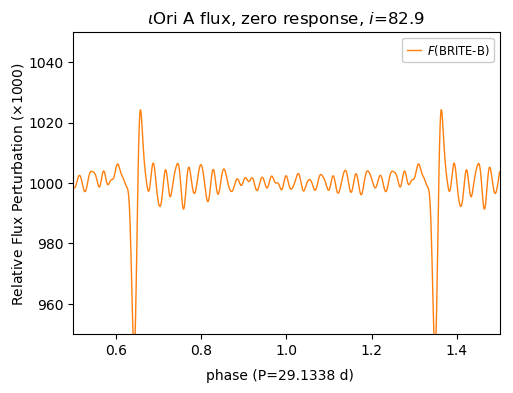

In [150]:
# Plot
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(5.5,4), dpi=100)

ax.plot(t*omega_orb, (flux_1 + 1.0)*1000, c='C1', lw=1, label=r'$F$(BRITE-B)')

ax.set_xlim(0.5,1.5)
ax.set_ylim(0.95*1000,1.05*1000)

legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}
ax.legend(loc=1, **legend_style)

ax.set_title(f'$\iota$Ori A flux, zero response, $i$={inc}')

fig.text(0.01, 0.5, r'Relative Flux Perturbation ($\times 1000$)', va='center', rotation='vertical')
fig.text(0.5, 0.01, f"phase (P={1./omega_orb:4.4f} d)", ha='center')

fig.savefig(f'iOri_flux_zero.png')

### The Case Without Rotation

In [11]:
def read_response(filename):
    
    # Read data from gyre_response
    
    f = h5py.File(filename, 'r')
        
    xi_r_ref_re = f['xi_r']['re'][...]
    xi_r_ref_im = f['xi_r']['im'][...]
        
    lag_L_ref_re = f['lag_L']['re'][...]
    lag_L_ref_im = f['lag_L']['im'][...]
    
    k_max = f.attrs['k_max']
    l_max = f.attrs['l_max']
    
    Omega_rot = f.attrs['Omega_rot']
    Omega_orb = f.attrs['Omega_orb']
    
    f.close()
    
    return {'xi_r_ref': xi_r_ref_re + 1j*xi_r_ref_im,
            'lag_L_ref': lag_L_ref_re + 1j*lag_L_ref_im,
            'k_max': k_max,
            'l_max': l_max,
            'Omega_rot': Omega_rot,
            'Omega_orb': Omega_orb}

In [12]:
def Delta_R(data, i_l,i_m,i_k):

    return np.sqrt(4.*np.pi) * data['xi_r_ref'][i_k,i_m,i_l]
    
    
def Delta_T(data, i_l,i_m,i_k):
        
    xi_r_ref = data['xi_r_ref'][i_k,i_m,i_l]
    
    lag_L_ref = data['lag_L_ref'][i_k,i_m,i_l]
    
    return np.sqrt(4.*np.pi)*(lag_L_ref - 2*xi_r_ref)/4.
  

def Delta_G(data, i_l,i_m,i_k, m,k):
    
    xi_r_ref = data['xi_r_ref'][i_k,i_m,i_l]
    
    omega = -k*data['Omega_orb'] - m*data['Omega_rot']
    
    return np.sqrt(4*np.pi)*(-omega**2 - 2)*xi_r_ref

In [13]:
def R_lm(l,m, phi,theta, I,x):
    
    Rlm = (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:]
    
    Y = sph_harm(m,l, phi,theta)
    
    return Rlm[0]*Y


def T_lm(l,m, phi,theta, I,dI,x):
    
    Tlm = dI[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:]
    
    Y = sph_harm(m,l, phi,theta)
    
    return Tlm[0]*Y


def G_lm(l,m, phi,theta, I,dI,x):
    
    Glm = dI[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:]
    
    Y = sph_harm(m,l, phi,theta)
    
    return Glm[0]*Y

In [14]:
def eval_fourier (data, I,dI,x, theta_0, phi_0, terms=False):

    # Initialize the frequencies/amplitudes arrays
    f = np.arange(data['k_max']+1)*data['Omega_orb']
    A = np.zeros(data['k_max']+1, dtype=np.complex)
    
    if terms==True:
        A_R = np.zeros(data['k_max']+1, dtype=np.complex)
        A_T = np.zeros(data['k_max']+1, dtype=np.complex)
        A_G = np.zeros(data['k_max']+1, dtype=np.complex)

    # Loop over l, m and k
    
    for l in range(2, data['l_max']+1):
        for m in range(-l, l+1):
            for k in range(0, data['k_max']+1):

                i_l = l
                i_m = m + data['l_max']
                i_k = k

                Del_R = Delta_R(data, i_l,i_m,i_k)
                Del_T = Delta_T(data, i_l,i_m,i_k)
                Del_G = Delta_G(data, i_l,i_m,i_k, m,k)

                Yml = sph_harm(m, l, phi_0, theta_0)

                Rml = (2 + l)*(1 - l)*I[f'I_{x}_{l}'][:] / I[f'I_{x}_0'][:] * Yml
                Tml = dI[f'dlnTeff_{x}_{l}'][:] / I[f'I_{x}_0'][:] * Yml
                Gml = dI[f'dlng_{x}_{l}'][:] / I[f'I_{x}_0'][:] * Yml
                
                if k == 0:
                    if m == 0:
                        kappa = 0.5
                    elif m >= 1:
                        kappa = 1.
                    else:
                        kappa = 0.
                else:
                    kappa = 1.

                # Add the Fourier contribution
                
                A[i_k] += 2*kappa*(Del_R*Rml + Del_T*Tml + Del_G*Gml)
                
                if terms==True:
                    A_R[i_k] += 2*kappa * Del_R*Rml
                    A_T[i_k] += 2*kappa * Del_T*Tml
                    A_G[i_k] += 2*kappa* Del_G*Gml
        
    # Return data
    if terms==True:
        return f, A_R, A_T, A_G
    else:
        return f, A

# iOri , a binary

In [15]:
I = h5py.File('iOri-partials-2.h5','r')
dI = h5py.File('iOri-partials-2.h5','r')

In [16]:
gyre_data = read_response("../gyre_run/response.001.h5")

l_max = gyre_data['l_max']
k_max = gyre_data['k_max']

omega_orb = gyre_data['Omega_orb']

inc = 62.9
omega = 122.2

theta = inc/180 * np.pi
phi = (90-omega)/180 * np.pi

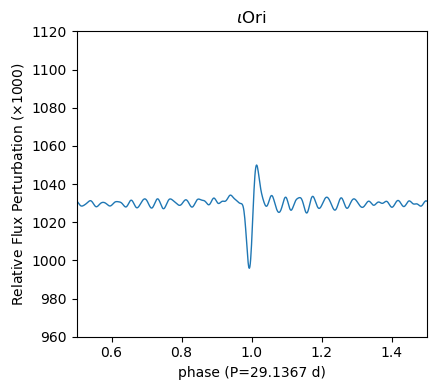

In [18]:
# Evaluate fourier terms
B,R='BRITE-B','BRITE-R'
t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 2001)

f, A_B = eval_fourier(gyre_data, I,dI,B, theta,phi, terms=False)
#_, A_R = eval_fourier(gyre_data, I,dI,R, theta,phi, terms=False)

# Initialize the frequencies/amplitudes arrays

diff_flux_B = np.zeros_like(t)
#diff_flux_R = np.zeros_like(t)

# Add contributions from each frequency component

n_A = len(A_B)

for i in range(n_A):

    diff_flux_B += np.real(A_B[i] * np.exp(1j*f[i]*2*np.pi*t))
#    diff_flux_R += np.real(A_R[i] * np.exp(1j*f[i]*2*np.pi*t))


fig, ax = plt.subplots( figsize=(4.5,4), dpi=100)


ax.plot(t*omega_orb, (diff_flux_B + 1.03)*1000, c='C0', lw=1, label='BRITE-B')

#ax.plot(t*omega_orb, (diff_flux_R + 1.0)*1000, c='C3', lw=1, label='BRITE-R')

ax.set_ylabel(r'Relative Flux Perturbation ($\times 1000$)')
ax.set_xlabel(f"phase (P={1./gyre_data['Omega_orb']:4.4f} d)")

ax.set_xlim(0.5,1.5)
ax.set_ylim(0.96*1000,1.12*1000)

#ax.legend()

ax.set_title(f'$\iota$Ori')
fig.tight_layout()
fig.savefig(f'iOri_concept.png')

### Synthetic BRITE Lightcurve

In [ ]:
# Evaluate fourier terms
B,R='BRITE-B','BRITE-R'
t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 1001)

f, A_B = eval_fourier(gyre_data, I,dI,B, theta,phi)
_, A_R = eval_fourier(gyre_data, I,dI,R, theta,phi)

# Initialize the frequencies/amplitudes arrays

diff_flux_B = np.zeros_like(t)
diff_flux_R = np.zeros_like(t)

# Add contributions from each frequency component

n_A = len(A_B)

for i in range(n_A):

    diff_flux_B += np.real(A_B[i] * np.exp(1j*f[i]*2*np.pi*t))
    
    diff_flux_R += np.real(A_R[i] * np.exp(1j*f[i]*2*np.pi*t))


fig, ax = plt.subplots( figsize=(8,4), dpi=300)

ax.plot(t*omega_orb, diff_flux_B + 1.03, c='C0', lw=1, label='BRITE-B')

ax.plot(t*omega_orb, diff_flux_R + 1.0, c='C3', lw=1, label='BRITE-R')

ax.set_ylabel('amplitude')
ax.set_xlabel(f"phase (P={1./gyre_data['Omega_orb']:4.4f} d)")

ax.set_xlim(0.6,1.6)
ax.set_ylim(0.96,1.12)

ax.legend()

ax.set_title(f'$\iota$Ori synthetic lightcurve')
fig.savefig(f'iOri_synBRITE.png')

### Inter-term Cancellation

In [ ]:
# Evaluate fourier terms
B,R='BRITE-B','BRITE-R'
t = np.linspace(-0.2/omega_orb, 2.2/omega_orb, 1001)

f, A_R, A_T,_ = eval_fourier(gyre_data, I,dI,B, theta,phi, terms=True)

# Initialize the frequencies/amplitudes arrays

diff_flux_R = np.zeros_like(t)
diff_flux_T = np.zeros_like(t)

# Add contributions from each frequency component

n_A = len(A_R)

for i in [2]:

    diff_flux_R += np.real(A_R[i] * np.exp(1j*f[i]*2*np.pi*t))
    diff_flux_T += np.real(A_T[i] * np.exp(1j*f[i]*2*np.pi*t))


fig, ax = plt.subplots( figsize=(8,4), dpi=100)

ax.plot(t*omega_orb, diff_flux_R, c='C1', lw=1, label=r'$\mathcal{R}$')

ax.plot(t*omega_orb, diff_flux_T, c='C2', lw=1, label=r'$\mathcal{T}$')

ax.set_ylabel('amplitude')
ax.set_xlabel(f"phase (P={1./gyre_data['Omega_orb']:4.4f} d)")

ax.set_xlim(0.,1.)

ax.legend()

ax.set_title(f'$\iota$Ori U flux terms')
fig.savefig(f'iOri_U_dff_xx{3}.png')

### color-moments

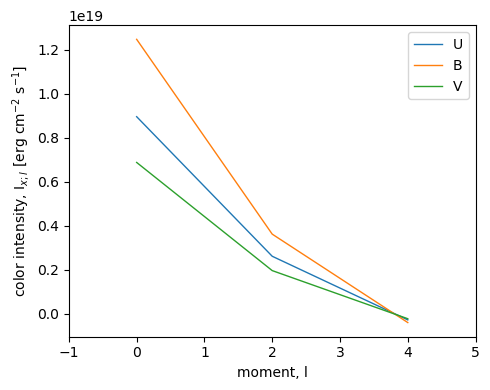

In [33]:
# Plot the results
fig, ax = plt.subplots( figsize=(5,4), dpi=100)

stepsize = 1
lw = 1

ax.plot([i for i in [0,2,4]], [spec[f'I_U_{i}'][:] for i in [0,2,4]]
        , label=r'U' , c='C0', lw=lw)
ax.plot([i for i in [0,2,4]], [spec[f'I_B_{i}'][:] for i in [0,2,4]]
        , label=r'B' , c='C1', lw=lw)
ax.plot([i for i in [0,2,4]], [spec[f'I_V_{i}'][:] for i in [0,2,4]]
        , label=r'V' , c='C2', lw=lw)

ax.set_xlabel(r'moment, l')
ax.set_ylabel(r'color intensity, I$_{x;l}$ [erg cm$^{-2}$ s$^{-1}$]')

ax.set_xlim(-1,5)

ax.legend()

#ax.set_title(r'Rotational Broadening')

fig.tight_layout()
fig.savefig('moment-vs-color-vrot10.png')

In [44]:
if spec.__bool__():
       spec.close()
if spvr.__bool__():
       spvr.close()


<b> Calculate Specific Flux </b>

$F_{\lambda}(d) = 2 \pi \cdot \frac{R_{\star}^2}{d^2} \int_0^1 I_{\lambda}(\mu) d\mu$

$\rightarrow F_{\lambda}= 2 \pi \int_0^1 I_{\lambda}(\mu) d\mu$

## Alnitak

https://arxiv.org/pdf/1306.0330.pdf